## Main Code for Data Import, Clean and Analysis

In [1]:
#Dependencies

import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import table
import seaborn as sns
import datetime as dt
from scipy.stats import linregress
import json
import requests
from api_keys import api_key

## Data Import and Clean

In [2]:
#crime statistics data
file = "datasource/WA Police Force Crime Timeseries.xlsx"
WAstats = pd.read_excel(file,sheet_name = "Data")
#fillna with 0 for 0 crime counts
WAstats.fillna(0, inplace = True)

In [3]:
#estimated resident population data
erpfile = "datasource/ERP.xls"
erp = pd.read_excel(erpfile,sheet_name = "Sheet1", header=2)
#drop nas for blank years
erp.dropna(inplace = True)
#change year column to datetime format
erp['Year (ending June 30)'] = pd.to_datetime(erp['Year (ending June 30)'], format='%Y')

In [4]:
#get google search trends on domestic violence
googlefile = "datasource/googlesearchdvastopic.csv"
dvgoogle = pd.read_csv(googlefile, header = 1)
dvgoogle['Month/Year'] = pd.to_datetime(dvgoogle['Week'], dayfirst=True).dt.to_period('M')
dvgooglemonthly = dvgoogle.groupby('Month/Year')['Domestic violence: (Australia)'].sum().reset_index()


googlerespectfile = "datasource/1800respect.csv"
respectsearch = pd.read_csv(googlerespectfile, header = 2)
respectsearch['Month/Year'] = pd.to_datetime(respectsearch['Week'], dayfirst=True).dt.to_period('M')
respectmonthly = respectsearch.groupby('Month/Year')['1800 respect: (Australia)'].sum().reset_index()


In [5]:
#population df manually created from website query data
population = {'Website Region' : ['Goldfields-Esperance District', 'Great Southern District',
        'Kimberley District',
       'Metropolitan Region', 'Mid West-Gascoyne District',
       'Pilbara District', 'South West District', 'Wheatbelt District','Western Australia'],
    'Population': [54363, 60993,35901,1900000, 62932,62093, 179791, 73437,2663561]}
pop_df = pd.DataFrame(population)

In [6]:
#guardian news api
url = f'https://content.guardianapis.com/search?q=domestic%20AND%20violence%20AND%20(lockdown%20OR%20coronavirus)&from-date=2020-03-01&page-size=200&api-key={api_key}'

response = requests.get(url)
news_json = response.json()


In [7]:
#print output
print(json.dumps(news_json, indent=4, sort_keys=True))

{
    "response": {
        "currentPage": 1,
        "orderBy": "relevance",
        "pageSize": 200,
        "pages": 5,
        "results": [
            {
                "apiUrl": "https://content.guardianapis.com/world/2021/mar/23/tuesday-briefing-domestic-abuse-lockdown",
                "id": "world/2021/mar/23/tuesday-briefing-domestic-abuse-lockdown",
                "isHosted": false,
                "pillarId": "pillar/news",
                "pillarName": "News",
                "sectionId": "world",
                "sectionName": "World news",
                "type": "article",
                "webPublicationDate": "2021-03-23T06:25:44Z",
                "webTitle": "Tuesday briefing: Domestic abuse reports surge amid lockdown",
                "webUrl": "https://www.theguardian.com/world/2021/mar/23/tuesday-briefing-domestic-abuse-lockdown"
            },
            {
                "apiUrl": "https://content.guardianapis.com/society/2021/mar/23/domestic-abuse-covid-lock

In [8]:
#print out headlines from first page
headlines = []
for r in news_json["response"]['results']:
    headlines.append(r['webTitle'])

In [9]:
#get total numer of dv and lockdown related articles
numberofarticles = news_json["response"]["pageSize"] * news_json["response"]["pages"]
print(numberofarticles)

1000


In [10]:
#dataframe of headslines from first page of API call
headlinedf = pd.DataFrame(headlines)
headlinedf.rename(columns={0:'Selection from 1000 headlines relating to domestic violence and lockdown'}, inplace=True)

In [11]:
#put headlines in table
headlinedf.to_csv("output/headlines.csv", encoding = "utf-8", index=False)
headlinedf.head(15)

,Selection from 1000 headlines relating to domestic violence and lockdown
0,Tuesday briefing: Domestic abuse reports surge...
1,Calls to domestic abuse helpline in England up...
2,Man who killed wife 'in act of great violence'...
3,"Morning mail: Quarantine complacency, Kidman o..."
4,Domestic abusers to get GPS tags on release fr...
5,Shock new figures fuel fears of more lockdown ...
6,Women killed in Spain as coronavirus lockdown ...
7,Fears grow for those facing domestic abuse as ...
8,Labour urges Patel to act on domestic abuse du...
9,Lockdown may have played part in rise of domes...


In [12]:
#list of regions
regionlist = WAstats['Website Region'].unique()
regionlist

array(['Armadale District', 'Cannington District', 'Fremantle District',
       'Goldfields-Esperance District', 'Great Southern District',
       'Joondalup District', 'Kimberley District', 'Mandurah District',
       'Metropolitan Region', 'Mid West-Gascoyne District',
       'Midland District', 'Mirrabooka District', 'Perth District',
       'Pilbara District', 'Regional WA Region', 'South West District',
       'Western Australia', 'Wheatbelt District'], dtype=object)

In [13]:
#list of crimes lvl2
basiccrimedesc = WAstats['WAPOL_Hierarchy_Lvl2'].unique()
basiccrimedesc

array(['Homicide', 'Recent Sexual Offences', 'Historical Sexual Offences',
       'Assault (Family)', 'Assault (Non-Family)',
       'Threatening Behaviour (Family)',
       'Threatening Behaviour (Non-Family)', 'Deprivation of Liberty',
       'Robbery', 'Burglary', 'Stealing of Motor Vehicle', 'Stealing',
       'Property Damage', 'Arson', 'Drug Offences',
       'Receiving and Possession of Stolen Property',
       'Regulated Weapons Offences', 'Graffiti',
       'Fraud & Related Offences', 'Breach of Violence Restraint Order'],
      dtype=object)

In [14]:
WAstats.head()

,Website Region,WAPOL_Hierarchy_order_Lvl1,WAPOL_Hierarchy_Lvl1,WAPOL_Hierarchy_order_Lvl2,WAPOL_Hierarchy_Lvl2,Period,Year,Key,MonthYear,COUNT_of_Offnc_ID
0,Armadale District,1.1,Murder,1,Homicide,2007-01-01,2006-07,Armadale DistrictMurderHomicide12007,12007,0.0
1,Armadale District,1.1,Murder,1,Homicide,2007-02-01,2006-07,Armadale DistrictMurderHomicide22007,22007,0.0
2,Armadale District,1.1,Murder,1,Homicide,2007-03-01,2006-07,Armadale DistrictMurderHomicide32007,32007,1.0
3,Armadale District,1.1,Murder,1,Homicide,2007-04-01,2006-07,Armadale DistrictMurderHomicide42007,42007,0.0
4,Armadale District,1.1,Murder,1,Homicide,2007-05-01,2006-07,Armadale DistrictMurderHomicide52007,52007,0.0


In [15]:
#All WA stats from 2019
WAstats2019 = WAstats[WAstats["Period"]>dt.datetime(year=2019, month = 1, day = 1)]


In [16]:
#key crimes list
TopCrimes = WAstats.groupby('WAPOL_Hierarchy_Lvl2')["COUNT_of_Offnc_ID"].sum().sort_values(ascending = False)
keycrimes = TopCrimes[0:6].index.tolist()
keycrimes

['Stealing',
 'Property Damage',
 'Burglary',
 'Drug Offences',
 'Fraud & Related Offences',
 'Assault (Family)']

In [17]:
#grouped into region, time period and Lvl 2 crime
Grouped = WAstats.groupby(['Website Region','Period','WAPOL_Hierarchy_Lvl2'])['COUNT_of_Offnc_ID'].sum().reset_index()
#merge with population 
GroupedRates = pd.merge(Grouped, pop_df,on='Website Region')
#calculate crime rate
GroupedRates['Rate'] = GroupedRates['COUNT_of_Offnc_ID']/(GroupedRates['Population'])*100000
#preview dataframe
GroupedRates.head()

,Website Region,Period,WAPOL_Hierarchy_Lvl2,COUNT_of_Offnc_ID,Population,Rate
0,Goldfields-Esperance District,2007-01-01,Arson,5.0,54363,9.197432
1,Goldfields-Esperance District,2007-01-01,Assault (Family),63.0,54363,115.887644
2,Goldfields-Esperance District,2007-01-01,Assault (Non-Family),71.0,54363,130.603535
3,Goldfields-Esperance District,2007-01-01,Breach of Violence Restraint Order,14.0,54363,25.752810
4,Goldfields-Esperance District,2007-01-01,Burglary,168.0,54363,309.033718


## Visualisations

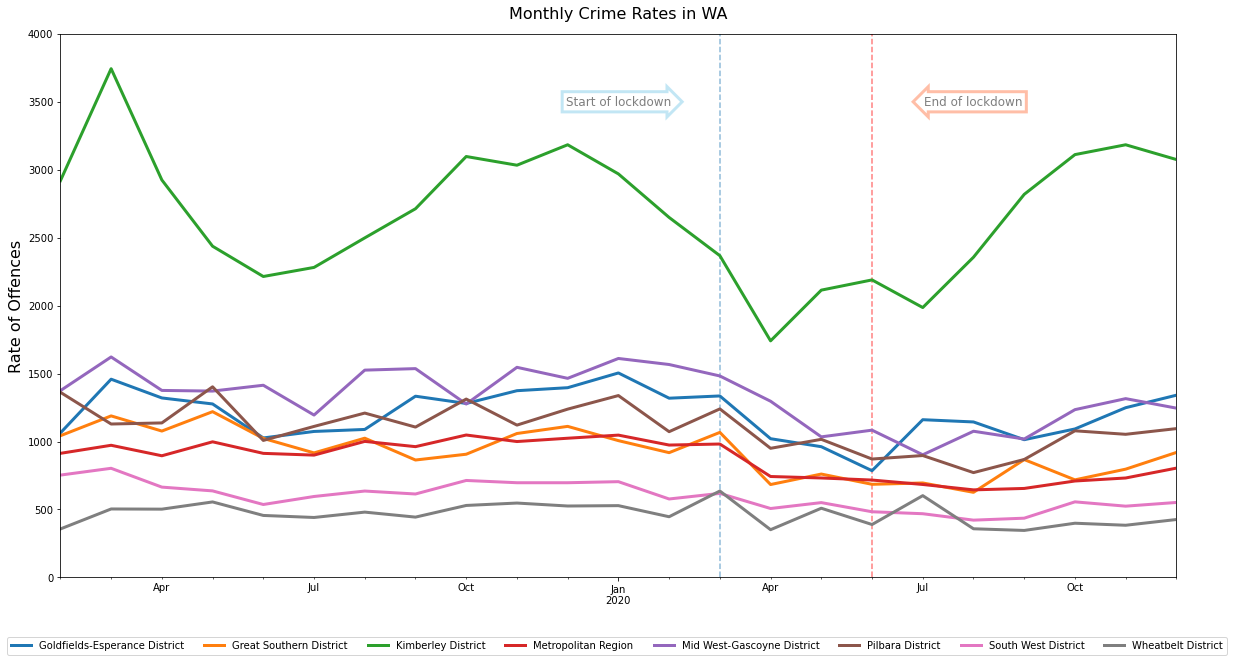

In [18]:
#get total crime rate per region from 2019
From2019 = GroupedRates[GroupedRates["Period"]>dt.datetime(year=2019, month = 1, day = 1)]
TotalCrimeRate = From2019.groupby(['Website Region','Period'])['Rate'].sum().reset_index()
RegionalCrimeRate = TotalCrimeRate[(TotalCrimeRate['Website Region']!='Western Australia')]
#pivot for graphing
TotalCrimesPivot = RegionalCrimeRate.pivot(index='Period', columns='Website Region', values='Rate')
#make chart
TotalCrimesPivot.plot(figsize=(20,10),linewidth=3)
plt.legend(bbox_to_anchor = (1.05, -0.1), ncol=8)
plt.text(
    "2020-01", 3500, "Start of lockdown", alpha =0.5,ha="center", va="center", rotation=0, size=12,
    bbox=dict(boxstyle="rarrow,pad=0.3", fc="white", ec="skyblue", alpha=0.5, lw=3))
plt.text(
    "2020-08", 3500, "End of lockdown", alpha =0.5,ha="center", va="center", rotation=0, size=12,
    bbox=dict(boxstyle="larrow,pad=0.3", fc="white", ec="coral", alpha=0.5, lw=3))
plt.vlines("2020-03",ymin = 0, ymax = 4000,linestyles='dashed', alpha=0.5)
plt.vlines("2020-06",ymin = 0, ymax = 4000, colors ="red",linestyles='dashed', alpha=0.5)
plt.ylim(0,4000)
plt.title("Monthly Crime Rates in WA", fontsize= 16,pad=15)
plt.ylabel("Rate of Offences",fontsize=16)
plt.xlabel('')
plt.savefig("output/crimeratesregions.png",bbox_inches='tight')
plt.show()

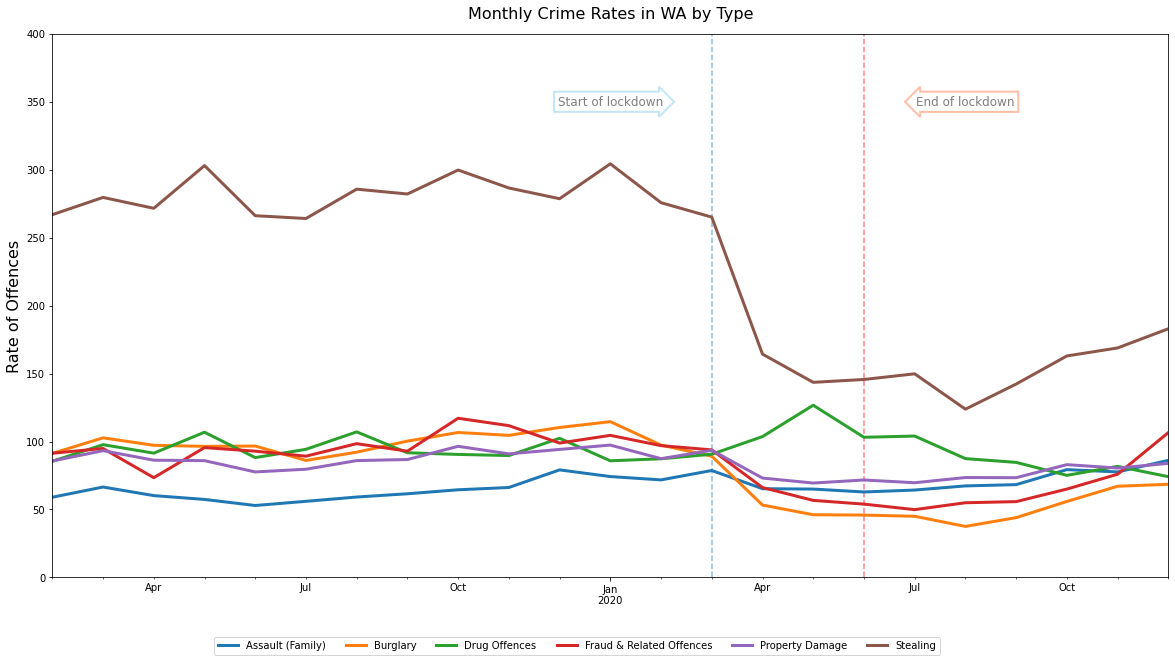

In [19]:
#get rates of key crimes
WARate = From2019[From2019['Website Region']=='Western Australia']
CrimeTypeRate = WARate[WARate['WAPOL_Hierarchy_Lvl2'].isin(keycrimes)]
CrimeTypeRate = CrimeTypeRate.groupby(['WAPOL_Hierarchy_Lvl2','Period'])['Rate'].sum().reset_index()
#pivot for graphing
CrimesPivot = CrimeTypeRate.pivot(index='Period', columns='WAPOL_Hierarchy_Lvl2', values='Rate')
#make chart
CrimesPivot.plot(figsize=(20,10),linewidth=3)
plt.legend(bbox_to_anchor = (0.8, -0.1),ncol=6)
plt.text(
    "2020-01", 350, "Start of lockdown", alpha =0.5,ha="center", va="center", rotation=0, size=12,
    bbox=dict(boxstyle="rarrow,pad=0.3", fc="white", ec="skyblue", alpha=0.5, lw=2))
plt.text(
    "2020-08", 350, "End of lockdown", alpha =0.5,ha="center", va="center", rotation=0, size=12,
    bbox=dict(boxstyle="larrow,pad=0.3", fc="white", ec="coral", alpha=0.5, lw=2))
plt.vlines("2020-03",ymin = 0, ymax = 500,linestyles='dashed', alpha=0.5)
plt.vlines("2020-06",ymin = 0, ymax = 500, colors ="red",linestyles='dashed', alpha=0.5)
plt.ylim(0,400)
plt.title("Monthly Crime Rates in WA by Type", fontsize= 16,pad=15)
plt.ylabel("Rate of Offences", fontsize=16)
plt.xlabel("")
plt.savefig("output/crimetyperatesregions.png",bbox_inches='tight')
plt.show()

In [20]:
#set time frames of pre, into and post lockdown
timeframescrime = WARate[(WARate['Period']=='2020-02')|(WARate['Period']=='2020-05')|(WARate['Period']=='2020-07')]
timeframescrime = timeframescrime[["WAPOL_Hierarchy_Lvl2",'Period','Rate']]
timeframescrime= timeframescrime.pivot(index='Period', columns='WAPOL_Hierarchy_Lvl2', values='Rate')

timeframescrime.index =["Pre-Lockdown","Lockdown", "Post-Lockdown"]

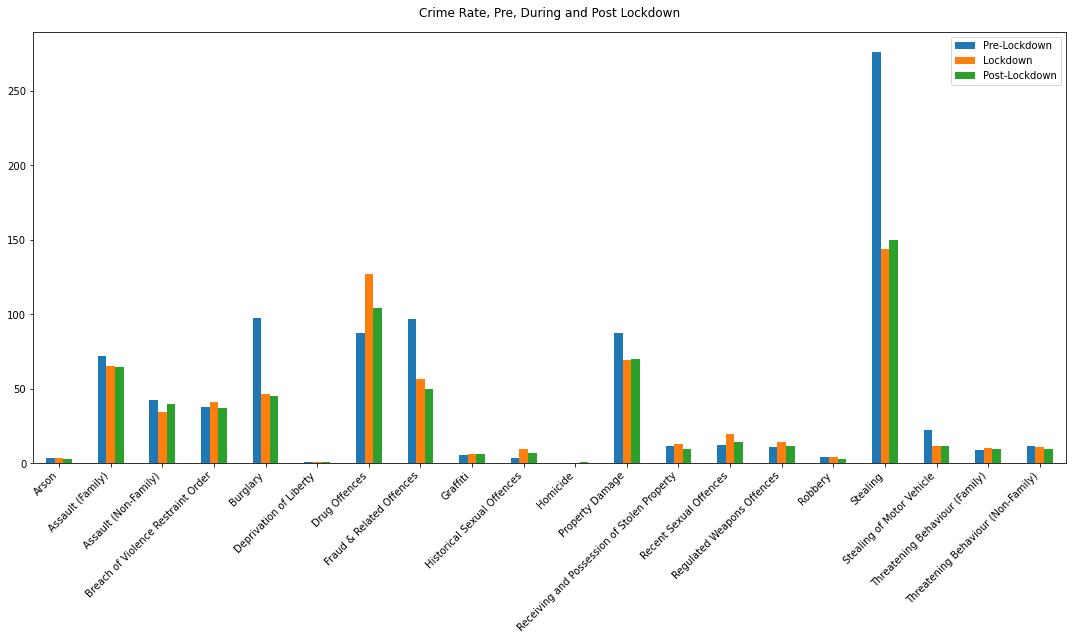

In [21]:
Transposedtime = timeframescrime.T
Transposedtime.plot.bar(figsize=(15,10))
plt.title("Crime Rate, Pre, During and Post Lockdown", pad=15)
plt.tight_layout()

plt.xlabel("")
plt.xticks(rotation="45",ha='right')
plt.savefig("output/crimeratesperiodbar.png",bbox_inches='tight')
plt.show()


In [22]:
#label function 
def addlabel(x,y,z):
    for i in range(len(x)):
        plt.text(i,(y[i]-z , y[i]+1)[y[i]>0],f"{x[i]}",ha='center')

In [23]:
#percent label function
def addlabel2(x,y,z):
    for i in range(len(x)):
        plt.text(i,(-z , 4)[y[i]>0],f"{x[i]}%",ha='center',color='w')

In [24]:
#get percentage change crime


crimepercent = timeframescrime.pct_change().multiply(100).round(1).reset_index()
crimechange = timeframescrime.diff().round(1).reset_index()

crimesin = crimechange[crimechange['index']=='Lockdown'].T
crimespercentin = crimepercent[crimepercent['index']=='Lockdown'].T

crimesin.to_csv("output/crimesinto.csv", encoding = "utf-8", index=True)

crimesmerge = pd.merge(crimesin,crimespercentin,on="WAPOL_Hierarchy_Lvl2")
crimesmerge = crimesmerge.drop(labels="index", axis=0)
crimesmerge.sort_values(by='1_x', inplace = True)

crimesmerge

,1_x,1_y
WAPOL_Hierarchy_Lvl2,,
Stealing,-132.2,-47.9
Burglary,-51.2,-52.6
Fraud & Related Offences,-40.3,-41.5
Property Damage,-17.9,-20.5
Stealing of Motor Vehicle,-10.9,-48.3
Assault (Non-Family),-7.9,-18.7
Assault (Family),-6.8,-9.4
Threatening Behaviour (Non-Family),-0.6,-4.9
Arson,-0.2,-6.8


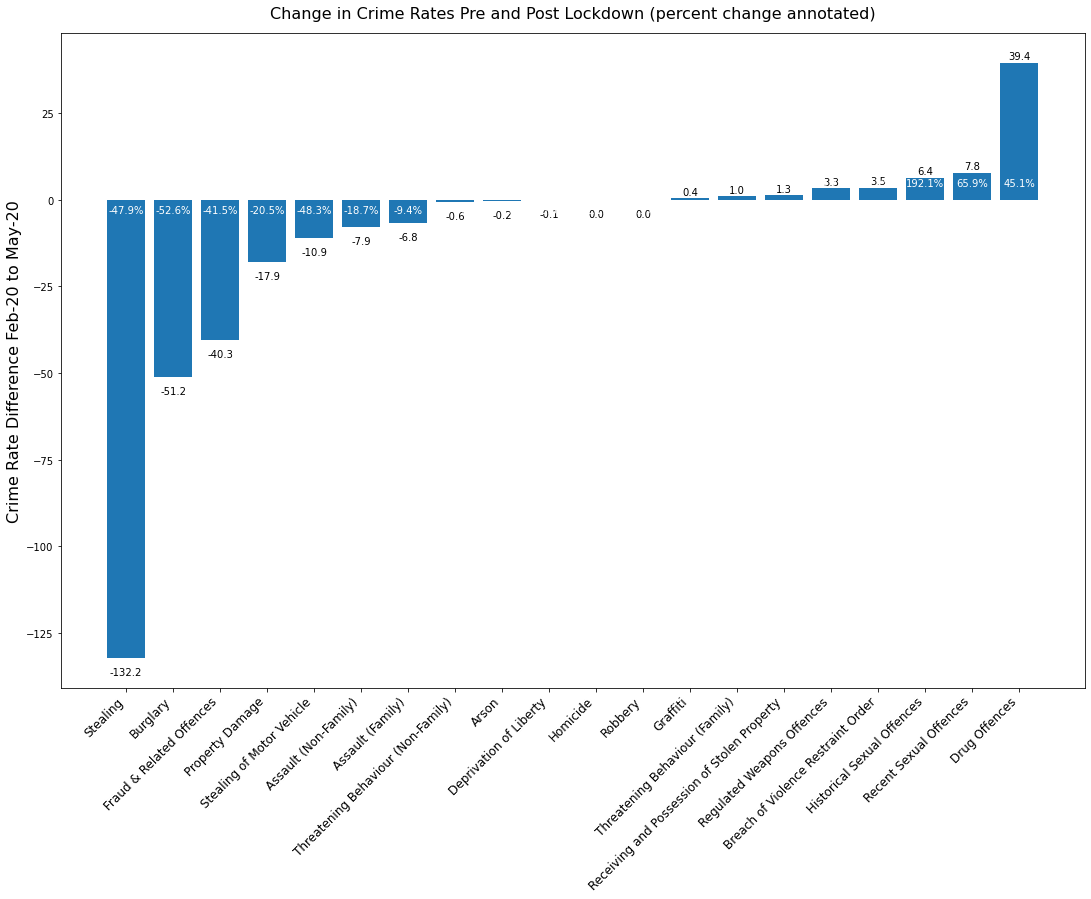

In [25]:
#bar chart of all crimes
plt.figure(figsize = (15,10))
plt.bar(crimesmerge.index,crimesmerge['1_x'])
plt.title("Change in Crime Rates Pre and Post Lockdown (percent change annotated)", fontsize=16,pad=15)
plt.tight_layout()
plt.xlabel("")
plt.ylabel("Crime Rate Difference Feb-20 to May-20",fontsize=16)
addlabel(crimesmerge['1_x'],crimesmerge['1_x'],5)
addlabel2(crimesmerge['1_y'],crimesmerge['1_x'],4)
plt.xticks(rotation="45",ha='right',fontsize=12)
plt.savefig("output/crimespreandpostbar.png",bbox_inches='tight')
plt.show()

In [26]:
#crimes differences
crimesout = crimechange[crimechange['index']=='Post-Lockdown']
crimesout = crimesout.T.drop(labels="index", axis=0)
crimesout.to_csv("output/crimesout.csv", encoding = "utf-8", index=True)
crimesout.sort_values(by=[2])

,2
WAPOL_Hierarchy_Lvl2,
Drug Offences,-22.7
Fraud & Related Offences,-6.8
Recent Sexual Offences,-5.4
Breach of Violence Restraint Order,-4.2
Receiving and Possession of Stolen Property,-3.3
Regulated Weapons Offences,-3.1
Historical Sexual Offences,-2.7
Robbery,-1.4
Threatening Behaviour (Non-Family),-1.4


In [27]:
#Whealbelt Region only
WBR = From2019[From2019['Website Region']=='Wheatbelt District']
TopCrimesWBR = WBR.groupby('WAPOL_Hierarchy_Lvl2')["COUNT_of_Offnc_ID"].sum().sort_values(ascending = False)
keycrimesWBR = TopCrimes[0:6].index.tolist()
keycrimesWBR

['Stealing',
 'Property Damage',
 'Burglary',
 'Drug Offences',
 'Fraud & Related Offences',
 'Assault (Family)']

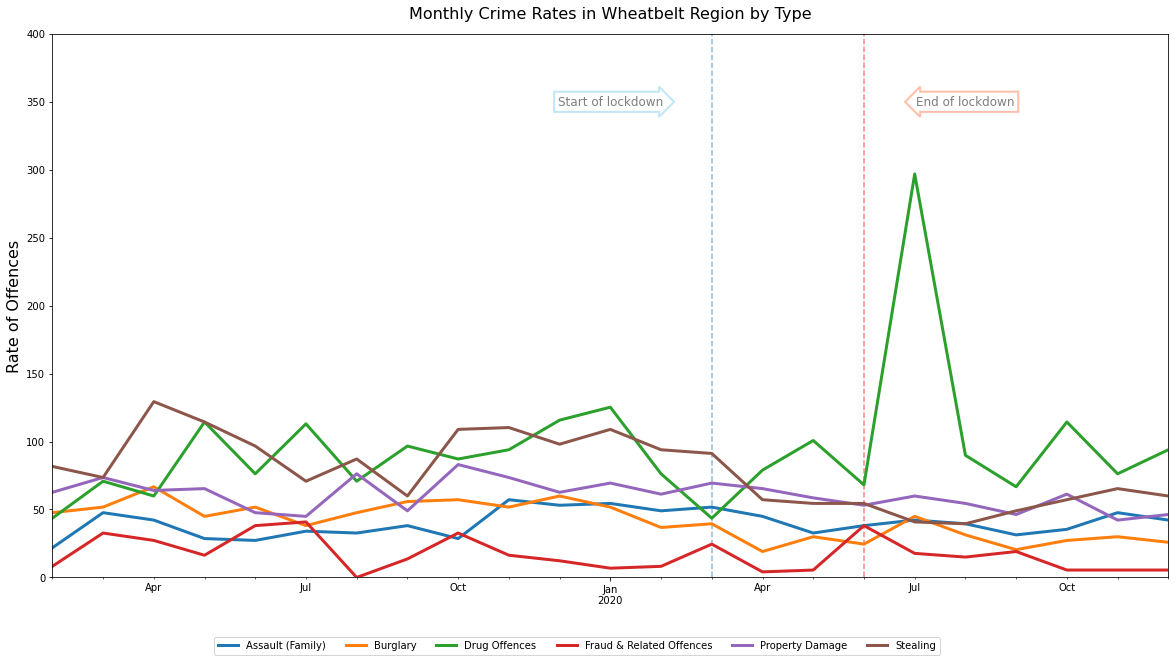

In [28]:
#get rates of key crimes
WBRkey = WBR[WBR['WAPOL_Hierarchy_Lvl2'].isin(keycrimesWBR)]
WBRkey = WBRkey.groupby(['Period','WAPOL_Hierarchy_Lvl2'])['Rate'].sum().reset_index()
#pivot for graphing
WBRPivot = WBRkey.pivot(index='Period', columns='WAPOL_Hierarchy_Lvl2', values='Rate')
#make chart
WBRPivot.plot(figsize=(20,10),linewidth=3)
plt.legend(bbox_to_anchor = (0.8, -0.1), ncol=6)
plt.text(
    "2020-01", 350, "Start of lockdown", alpha =0.5,ha="center", va="center", rotation=0, size=12,
    bbox=dict(boxstyle="rarrow,pad=0.3", fc="white", ec="skyblue", alpha=0.5, lw=2))
plt.text(
    "2020-08", 350, "End of lockdown", alpha =0.5,ha="center", va="center", rotation=0, size=12,
    bbox=dict(boxstyle="larrow,pad=0.3", fc="white", ec="coral", alpha=0.5, lw=2))
plt.vlines("2020-03",ymin = 0, ymax = 500,linestyles='dashed', alpha=0.5)
plt.vlines("2020-06",ymin = 0, ymax = 500, colors ="red",linestyles='dashed', alpha=0.5)
plt.ylim(0,400)
plt.title("Monthly Crime Rates in Wheatbelt Region by Type", fontsize=16, pad=15)
plt.ylabel("Rate of Offences",fontsize=16)
plt.xlabel('')
plt.savefig("output/wbrcrimerates.png",bbox_inches='tight')
plt.show()

In [29]:
#set time frames of pre, into and post lockdown
timeframes = TotalCrimeRate[(TotalCrimeRate['Period']=='2020-02')|(TotalCrimeRate['Period']=='2020-05')|(TotalCrimeRate['Period']=='2020-07')]
timeframes = timeframes[["Website Region",'Period','Rate']]
timeframes.head()


,Website Region,Period,Rate
12,Goldfields-Esperance District,2020-02-01,1318.911760
15,Goldfields-Esperance District,2020-05-01,962.051395
17,Goldfields-Esperance District,2020-07-01,1160.715928
35,Great Southern District,2020-02-01,918.138147
38,Great Southern District,2020-05-01,760.743036


In [30]:
#get percentage change
overallpercentchange = timeframes.set_index(["Website Region",'Period']).pct_change().multiply(100).round(1).reset_index()
overallchange = timeframes.set_index(["Website Region",'Period']).diff().round(1)
overallchange.reset_index(inplace=True)
overallchange.head()

,Website Region,Period,Rate
0,Goldfields-Esperance District,2020-02-01,NaN
1,Goldfields-Esperance District,2020-05-01,-356.9
2,Goldfields-Esperance District,2020-07-01,198.7
3,Great Southern District,2020-02-01,-242.6
4,Great Southern District,2020-05-01,-157.4


In [31]:
#get data into separate tables for map plotting
Regionsinto = overallchange[overallchange['Period']=='2020-05-01']
Regionspercentinto = overallpercentchange[overallpercentchange['Period']=='2020-05-01']
Regionsout = overallchange[overallchange['Period']=='2020-07-01']
Regionsinto.to_csv("output/Regionsinto.csv", encoding = "utf-8", index=False)
Regionsout.to_csv("output/Regionsout.csv", encoding = "utf-8", index=False)

In [32]:
Regionsinto.describe()

,Rate
count,9.000000
mean,-227.677778
std,213.154309
min,-534.800000
25%,-356.900000
50%,-204.900000
75%,-56.400000
max,62.600000


In [33]:
print(Regionsinto.loc[Regionsinto['Rate'].idxmax(axis=0)])
print(Regionsinto.loc[Regionsinto['Rate'].idxmin(axis=0)])


Website Region     Wheatbelt District
Period            2020-05-01 00:00:00
Rate                             62.6
Name: 25, dtype: object
Website Region     Kimberley District
Period            2020-05-01 00:00:00
Rate                           -534.8
Name: 7, dtype: object


In [34]:
Regionsinto = Regionsinto.drop('Period',axis=1).sort_values("Rate").set_index('Website Region')
Regionspercentinto = Regionspercentinto.drop('Period',axis=1).sort_values("Rate").set_index('Website Region')

In [35]:
Regionsmerge = pd.merge(Regionsinto,Regionspercentinto,on="Website Region")
Regionsmerge=Regionsmerge.drop('Western Australia',axis=0)

<ipython-input-22-0f14de8a2690>:4: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  plt.text(i,(y[i]-z , y[i]+1)[y[i]>0],f"{x[i]}",ha='center')


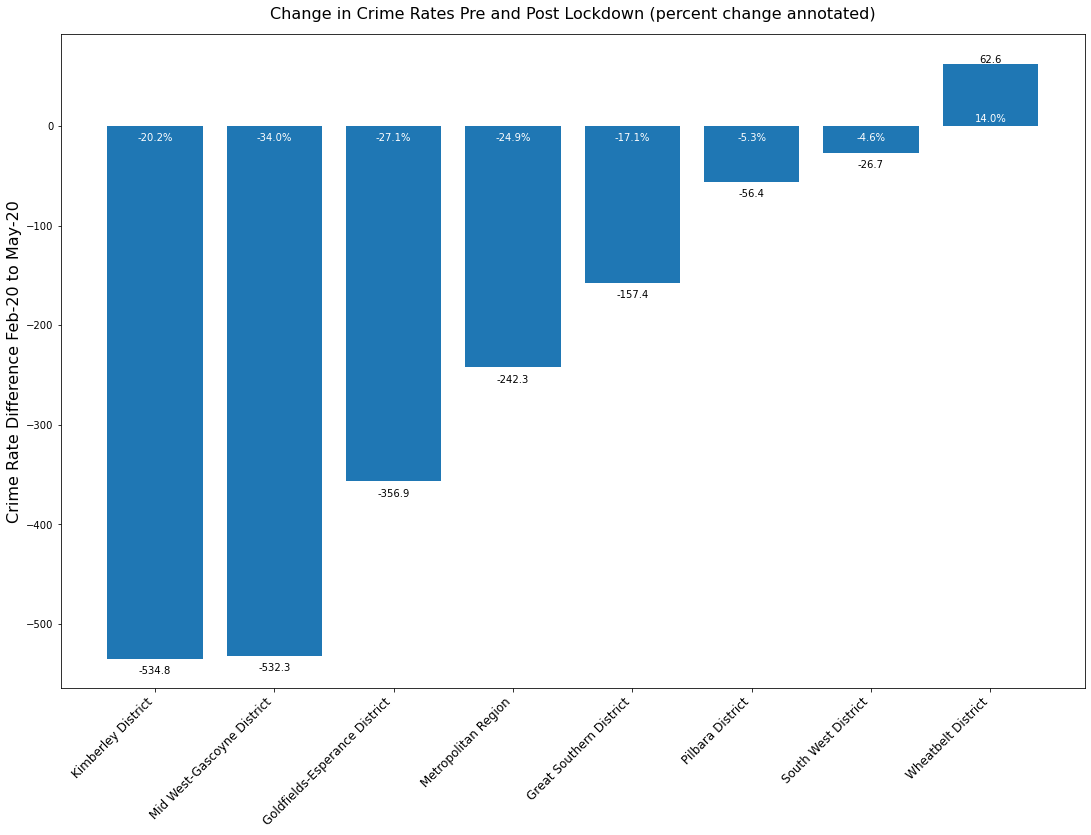

In [36]:
#bar chart of all regions

plt.figure(figsize = (15,10))
plt.bar(Regionsmerge.index,Regionsmerge['Rate_x'])
plt.title("Change in Crime Rates Pre and Post Lockdown (percent change annotated)", fontsize=16,pad=15)
plt.tight_layout()
plt.xlabel("")
plt.ylabel("Crime Rate Difference Feb-20 to May-20",fontsize=16)
addlabel(Regionsmerge['Rate_x'],Regionsmerge['Rate_x'],15)
addlabel2(Regionsmerge['Rate_y'],Regionsmerge['Rate_x'],15)
plt.xticks(rotation="45",ha='right',fontsize=12)
plt.savefig("output/regionspreandpostbar.png",bbox_inches='tight')
plt.show()



In [37]:
#get breach of AVO family
Groupedlvl1 = WAstats.groupby(['Website Region','Period','WAPOL_Hierarchy_Lvl1'])['COUNT_of_Offnc_ID'].sum().reset_index()
Groupedlvl1rates = pd.merge(Groupedlvl1, pop_df,on='Website Region')
#calculate crime rate
Groupedlvl1rates['Rate'] = Groupedlvl1rates['COUNT_of_Offnc_ID']/(Groupedlvl1rates['Population'])*100000
#preview dataframe
FamilyAVO = Groupedlvl1rates[Groupedlvl1rates['WAPOL_Hierarchy_Lvl1']=='Breach of Family Violence Restraint Order']
FamilyAVO.rename({'WAPOL_Hierarchy_Lvl1':'WAPOL_Hierarchy_Lvl2'}, axis=1,inplace=True)

C:\Users\fernb\anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [38]:
#get domestic violence data per region
Domesticviolence = GroupedRates[((GroupedRates["WAPOL_Hierarchy_Lvl2"]=="Assault (Family)")|(GroupedRates["WAPOL_Hierarchy_Lvl2"]=="Threatening Behaviour (Family)"))]
#append family avo rates
Domesticviolence = Domesticviolence.append(FamilyAVO, ignore_index = True)
Domesticviolence = Domesticviolence.replace({'Assault (Family)':'Domestic Violence','Threatening Behaviour (Family)':'Domestic Violence','Breach of Family Violence Restraint Order':'Domestic Violence'})
Domesticviolence = Domesticviolence.groupby(["Website Region",'Period','WAPOL_Hierarchy_Lvl2'])['Rate'].sum().reset_index()
Domesticviolencecovid = Domesticviolence[((Domesticviolence["Period"]=="2020-02")|(Domesticviolence["Period"]=="2020-05")|(Domesticviolence["Period"]=="2020-07"))]


In [39]:
Domesticviolencecovid.head()

,Website Region,Period,WAPOL_Hierarchy_Lvl2,Rate
157,Goldfields-Esperance District,2020-02-01,Domestic Violence,218.898883
160,Goldfields-Esperance District,2020-05-01,Domestic Violence,206.022479
162,Goldfields-Esperance District,2020-07-01,Domestic Violence,275.922962
325,Great Southern District,2020-02-01,Domestic Violence,134.441657
328,Great Southern District,2020-05-01,Domestic Violence,131.162592


In [40]:
#get change in dv between time periods
Domesticviolencechange = Domesticviolencecovid.drop(columns="WAPOL_Hierarchy_Lvl2").set_index(["Website Region",'Period']).diff().round(1)
Domesticviolencepercentchange = Domesticviolencecovid.drop(columns="WAPOL_Hierarchy_Lvl2").set_index(["Website Region",'Period']).pct_change().multiply(100).round(1)

In [41]:
Domesticviolencechange.reset_index(inplace=True)
Domesticviolencepercentchange.reset_index(inplace=True)

In [42]:
#get dv change for each time period
Regionsdvin = Domesticviolencechange[Domesticviolencechange['Period']=='2020-05']
Redionsdvpercentin = Domesticviolencepercentchange[Domesticviolencepercentchange['Period']=='2020-05']
Regionsdvout = Domesticviolencechange[Domesticviolencechange['Period']=='2020-07']

In [43]:
Regionsdvin.describe()

,Rate
count,9.000000
mean,-3.244444
std,30.055661
min,-52.400000
25%,-12.900000
50%,-4.800000
75%,-3.300000
max,47.400000


In [44]:
print(Regionsdvin.loc[Regionsdvin['Rate'].idxmax(axis=0)])
print(Regionsdvin.loc[Regionsdvin['Rate'].idxmin(axis=0)])

Website Region     Kimberley District
Period            2020-05-01 00:00:00
Rate                             47.4
Name: 7, dtype: object
Website Region    Mid West-Gascoyne District
Period                   2020-05-01 00:00:00
Rate                                   -52.4
Name: 13, dtype: object


In [45]:
#save to csv for map plot
Regionsdvin.to_csv("output/Regionsdvinto.csv", encoding = "utf-8", index=False)
Regionsdvout.to_csv("output/Regionsdvout.csv", encoding = "utf-8", index=False)

In [46]:
Regionsdvin = Regionsdvin.drop('Period',axis=1).sort_values("Rate").set_index('Website Region')
Redionsdvpercentin = Redionsdvpercentin.drop('Period',axis=1).sort_values("Rate").set_index('Website Region')

In [47]:
Regionsdvmerge = pd.merge(Regionsdvin,Redionsdvpercentin,on="Website Region")
Regionsdvmerge = Regionsdvmerge.drop('Western Australia',axis=0)

<ipython-input-22-0f14de8a2690>:4: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  plt.text(i,(y[i]-z , y[i]+1)[y[i]>0],f"{x[i]}",ha='center')


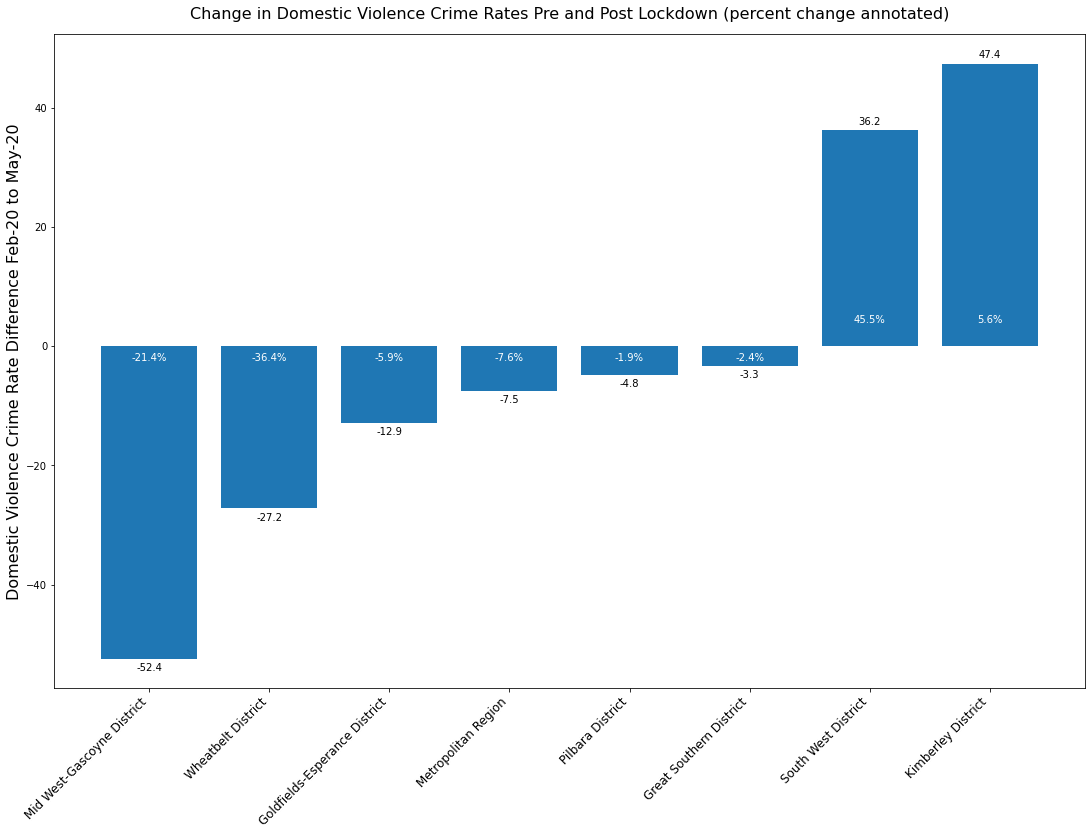

In [48]:
#bar chart of all regions


plt.figure(figsize = (15,10))
plt.bar(Regionsdvmerge.index,Regionsdvmerge['Rate_x'])
plt.title("Change in Domestic Violence Crime Rates Pre and Post Lockdown (percent change annotated)", fontsize=16,pad=15)
plt.tight_layout()
plt.xlabel("")
plt.ylabel("Domestic Violence Crime Rate Difference Feb-20 to May-20",fontsize=16)
addlabel(Regionsdvmerge['Rate_x'],Regionsdvmerge['Rate_x'],2)
addlabel2(Regionsdvmerge['Rate_y'],Regionsdvmerge['Rate_x'],2.5)
plt.xticks(rotation="45",ha='right',fontsize=12)
plt.savefig("output/dvpreandpostbar.png",bbox_inches='tight')
plt.show()


In [49]:
#pivot for graphing
Domesticviolence2019 = Domesticviolence[Domesticviolence["Period"]>dt.datetime(year=2019, month = 1, day = 1)]
DomesticviolenceRegion = Domesticviolence2019[Domesticviolence2019['Website Region']!='Western Australia']
DVpivot = DomesticviolenceRegion.drop(columns=["WAPOL_Hierarchy_Lvl2"]).pivot(index='Period', columns='Website Region', values='Rate')

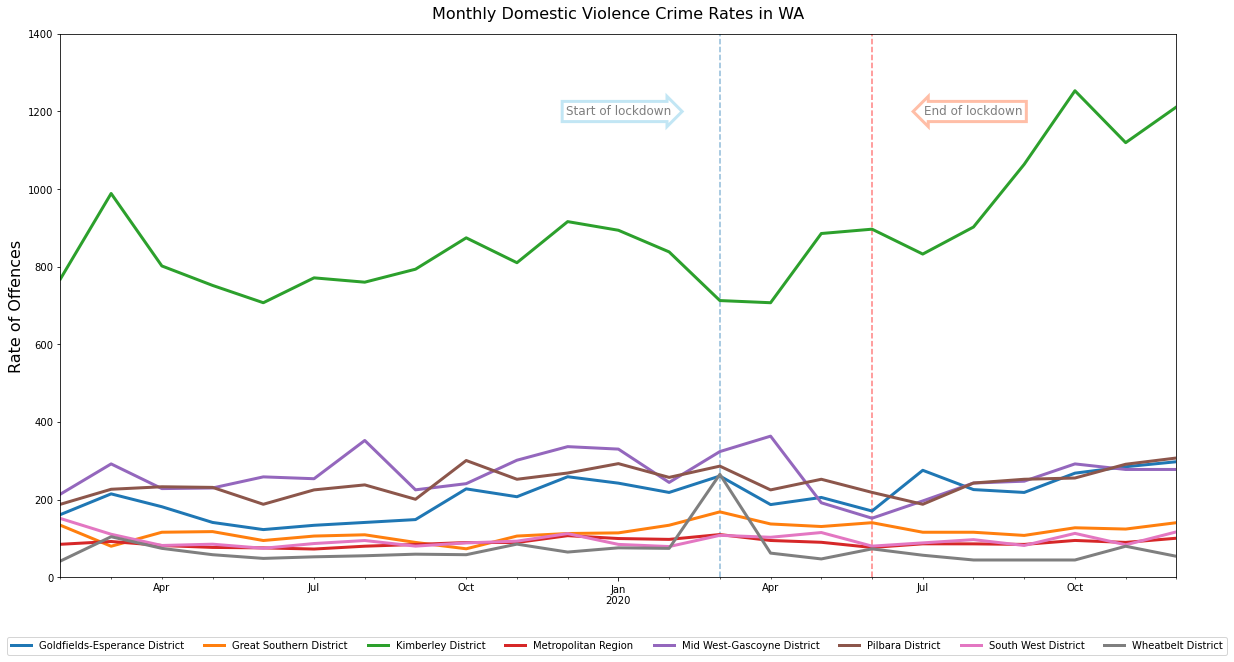

In [50]:
#plot dv chart
DVpivot.plot(figsize=(20,10),linewidth=3)
plt.legend(bbox_to_anchor = (1.05, -0.1),ncol=8)
plt.text(
    "2020-01", 1200, "Start of lockdown", alpha =0.5,ha="center", va="center", rotation=0, size=12,
    bbox=dict(boxstyle="rarrow,pad=0.3", fc="white", ec="skyblue", alpha=0.5, lw=3))
plt.text(
    "2020-08", 1200, "End of lockdown", alpha =0.5,ha="center", va="center", rotation=0, size=12,
    bbox=dict(boxstyle="larrow,pad=0.3", fc="white", ec="coral", alpha=0.5, lw=3))
plt.vlines("2020-03",ymin = 0, ymax = 1400,linestyles='dashed', alpha=0.5)
plt.vlines("2020-06",ymin = 0, ymax = 1400, colors ="red",linestyles='dashed', alpha=0.5)
plt.ylim(0,1400)
plt.title("Monthly Domestic Violence Crime Rates in WA",fontsize=16, pad=15)
plt.ylabel("Rate of Offences",fontsize=16)
plt.xlabel("")
plt.savefig("output/dvratesregions.png",bbox_inches='tight')
plt.show()

In [51]:
#DV in WA total
DomesticviolenceWA = Domesticviolence[Domesticviolence['Website Region']=='Western Australia']

In [52]:
#merge crime rates with google searches
dvsearches = pd.merge(DomesticviolenceWA,dvgooglemonthly, how='inner', left_on = DomesticviolenceWA['Period'].dt.strftime('%Y-%m'),right_on = dvgooglemonthly['Month/Year'].dt.strftime('%Y-%m'))
allsearches = pd.merge(dvsearches,respectmonthly, on= 'Month/Year')
allsearches.rename(columns ={'Rate':'Domestic Violence Offences','Domestic violence: (Australia)':'Google Searches: Domestic Violence','1800 respect: (Australia)':'Google Searches: 1800 respect'}, inplace=True)
allsearches2019 = allsearches[allsearches["Period"]>dt.datetime(year=2019, month = 1, day = 1)]

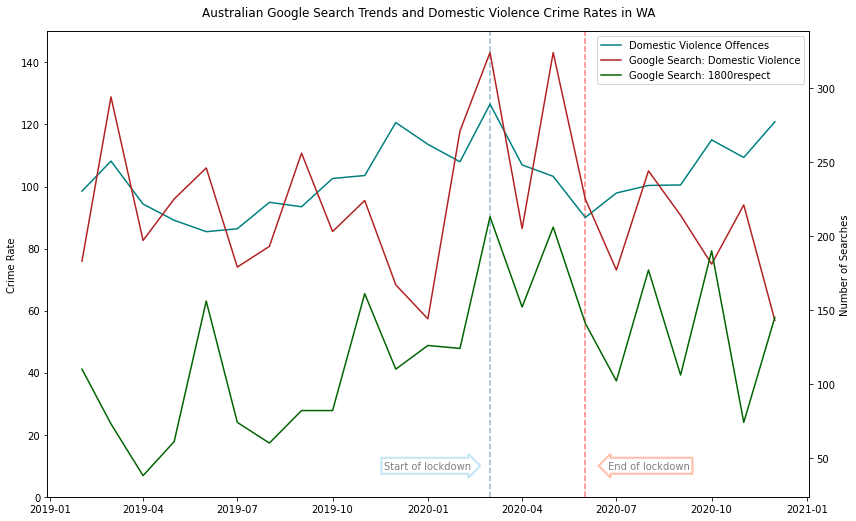

In [53]:
#plot crime and search data
fig, ax1 = plt.subplots(figsize=(12,7))


ax1.set_ylabel('Crime Rate')
ax1.plot(allsearches2019['Period'], allsearches2019['Domestic Violence Offences'],label = 'Domestic Violence Offences',color='teal')


ax2 = ax1.twinx() 

ax2.set_ylabel('Number of Searches')  
ax2.plot(allsearches2019['Period'], allsearches2019['Google Searches: Domestic Violence'],label = 'Google Search: Domestic Violence',color ='firebrick')
ax2.plot(allsearches2019['Period'], allsearches2019['Google Searches: 1800 respect'],label = 'Google Search: 1800respect',color ='darkgreen')

ax1.text(
    dt.datetime(year=2020, month = 1,day=1), 10, "Start of lockdown", alpha =0.5,ha="center", va="center", rotation=0, size=10,
    bbox=dict(boxstyle="rarrow,pad=0.3", fc="white", ec="skyblue", alpha=0.5, lw=2))
ax1.text(
    dt.datetime(year=2020, month = 8,day=1), 10, "End of lockdown", alpha =0.5,ha="center", va="center", rotation=0, size=10,
    bbox=dict(boxstyle="larrow,pad=0.3", fc="white", ec="coral", alpha=0.5, lw=2))
ax1.vlines(dt.datetime(year=2020, month = 3,day=1),ymin = 0, ymax = 150,linestyles='dashed', alpha=0.5)
ax1.vlines(dt.datetime(year=2020, month = 6,day=1),ymin = 0, ymax = 150, colors ="red",linestyles='dashed', alpha=0.5)
ax1.set_ylim(0,150)
fig.tight_layout() 
plt.title('Australian Google Search Trends and Domestic Violence Crime Rates in WA', pad=15)
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

lines = lines_1 + lines_2
labels = labels_1 + labels_2

ax1.legend(lines, labels, loc=0)
plt.savefig("output/googlesearchtrends.png",bbox_inches='tight')
plt.show()

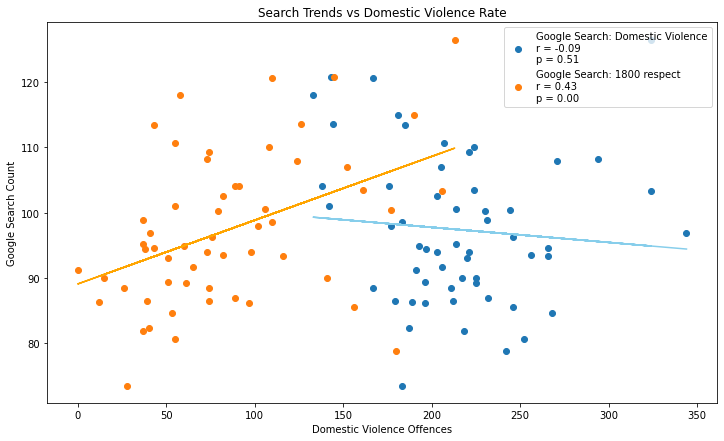

In [56]:
#regression to compare searches to rates
a=allsearches['Google Searches: Domestic Violence']
b=allsearches['Domestic Violence Offences']
c=allsearches['Google Searches: 1800 respect']

(aslope, aintercept, arvalue, apvalue, astderr) = linregress(a, b)
aregress_values = a * aslope + aintercept
aline_eq = "y = " + str(round(aslope,2)) + "x + " + str(round(aintercept,2))
(cslope, cintercept, crvalue, cpvalue, cstderr) = linregress(c, b)
cregress_values = c * cslope + cintercept
cline_eq = "y = " + str(round(cslope,2)) + "x + " + str(round(cintercept,2))


plt.figure(figsize=(12,7))
plt.scatter(a,b, label=f'Google Search: Domestic Violence\nr = {arvalue:.2f}\np = {apvalue:.2f}')
plt.scatter(c,b,label = f'Google Search: 1800 respect\nr = {crvalue:.2f}\np = {cpvalue:.2f}')
plt.legend()
plt.plot(c,cregress_values,'orange')
plt.plot(a,aregress_values,'skyblue')
plt.xlabel("Domestic Violence Offences")
plt.ylabel("Google Search Count")
plt.title("Search Trends vs Domestic Violence Rate")

plt.savefig("output/searchregressionstogether.png",bbox_inches='tight')

plt.show()


## Summary
We initially wanted to look at the occurance of domestic violence during the covid lockdown periods in WA as we had heard about National and International observations of increases in domestic violence during these periods. Unfortunately we could not find and recent domestic violence specific statists to correlate with the March 2020 to June 2020 lockdown in WA. We then decided to look at WA crime statistics as a whole thinking that maybe we could gain insites from domestic violence from those. 

Our hypothesis was: <br> 
> During the lockdown period in WA, March 2020 to June 2020, <br> 
> there would be an increase in domestic violence crimes.
 
The monthly statistics from the [Western Australian Police Force Crime Statistics Report](https://www.police.wa.gov.au/Crime/CrimeStatistics#/) were imported into a pandas dataframe and cleaned, we then created several visualisations to examine the crime trends for total WA crime. We grouped the statistic by WAPOL Hierarchy Lvl2 classifications to reduce the number of data points. We limited our reveiw to data from Jan 2019 to Dec 2020. Overall there was a decrease in crime rates with some minor increases in things like Drugs and Non-Assaultive Sexual Offences. We did not observe any increase in Assault (Family) and Threatening Behaviour (Family).

We used [The Gaurdian API](https://open-platform.theguardian.com/) to retrieve articles relating to domestic violence and lockdown from March 2020 to confirm if our recollection of reported trends were accurate and approximately 1000 articles were retrieved. Examination of headlines showed that there was a noted increased nationally and internationally.

We then decided to examine the crime data from a different angle and grouped trends by region rather than specific crimes. We realised we had to normalise the crime data to be able to accurately compare across regions so we used the internationally recognised standard for calculating crime rate per 100,000 people as specified by [WAPOL](https://www.police.wa.gov.au/Crime/CrimeStatistics/Explanatory-Notes):
> Offence rate per 100,000 = (Offence count ÷ Estimated Resident Population) × 100,000

The Estimated Resident Population (ERP) for WA and each region was obtained from a report generated on the [WA Parlimentary Library](https://profile.id.com.au/wapl/population-estimate?BMID=40). Initial visualisations were recreated using the crime rate statisitics. Total crime rates were plotted per region over time, all regions experienced a decrease in crime except for the Wheatbelt district. 

To more accurately measure domestic violence crime we aggregated Assault (Family) and Threatening Behaviour (Family) crime rates, from WAPOL Hierarchy Lvl2 and appended Breach of Family Violence Restraint Order crime rates from WAPOL Hierarchy Lvl1 into one column, we noted that some instances of sexual assualt may also be considered domestic violence but we were unable to separate that into family specific offences.

Monthly domestic violence crime rates were plotted over time and it was observed that most districts had a decrease in domestic violence except South West (rate increase of 36, 45% increase) and Kimberley (rate increase of 47, 5% increase). Kimberley continued to have an increase in domestic violence even after the lockdown period had ended. A map was generated by using geopandas to import [police district boundary polygons](https://catalogue.data.wa.gov.au/dataset/wa-police-district-boundaries) and merge with the table containing the calculated differences in crime rate and domestic violence rate between Feb 20 (pre lockdown) and May 20 (into lockdown).

We decided that crime rates may not give a full indication of the ammount of domestic violence occuring as it has been previously noted by the [ABS Personal Safety Report](https://www.abs.gov.au/statistics/people/crime-and-justice/personal-safety-australia/latest-release) and [Crime Victimisation Report](https://www.abs.gov.au/statistics/people/crime-and-justice/crime-victimisation-australia/latest-release) that domestic violence crimes and violent crimes in general are under reported.

We searched for statistics for calls to domestic violence help lines but none were readily available to us so we decided to use [google search trends](https://trends.google.com/trends/?geo=AU) as a surrogate. We filtered the search trend data by Australia as there was insufficient data to trend for Western Australia. We used "Domestic Violence" as a topic and the national helpline "1800respect" as a search term and collected data for both. We plotted the number of searches against domestic violence crime rate and calculated the regressions. There was almost no correlation between "Domestic Violence" searches and domestic violence crime rate (r=-0.09) but there was a weak positive correlation between "1800respect" and domestic violence crime rate (r = 0.43), the p value was almost zero which means that this correlation is statistically significant.

## Conclusion
In conclusion the data partially supported our hypothesis that there would be an observable increase in domestic violence crime during the lockdown period in WA in 2020 however this was observed only in two regions in WA, South West and Kimberley.

We found it difficult to determine an accurate represenation of domestic violence through crime rate statistics due to the complex nature of domestic violence, the way in which the statistics are reported and the general understanding that not all instances of domestic violence are reported as a crime.

Further exploration into this topic could include finding more surrogates for domestic violence rates such as statistics for accessing specialised services, further investigation into different google searches, correlating data from the personal safety report with national crime statistics. These factors could be used to form algorithms to use in predictive policing, an emerging tactic in modern crime reduction.
